# Building an MMA Fight Analyzer Using Machine Learning 

As a Mixed Martial Arts fan, I thought it would be interesting to analyze fight data to see what insights could be drawn and inferences made as to the in-fight factors affecting the outcome. I found a dataset on Kaggle containing data on nearly 3000 fights that took place between 2013-17 in the Ultimate Fighting Championship (UFC), a US-based MMA promotion. After removing rows with mostly missing data, the dataset was reduced to 1791 rows. I then decided to remove fights that ended in draws and no-contests, which further reduced the size of the final dataset to 1762. 

<img src="45915287272_598aa86b38_b_van.jpg" width="1080"
alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />

photo credit: MAZA FIGHT JAPAN <a href="http://www.flickr.com/photos/123913273@N06/45915287272">8Y9A4291-114</a> via <a href="http://photopin.com">photopin</a> <a href="https://creativecommons.org/licenses/by-nc-nd/2.0/">(license)</a>       

### The Task

The dataset consisted of some 453 rows representing characteristics both of the fight and of one of the fighters. These ranged from variables such as fighter age, current winning streak, and fighter height and weight, to factors like ground control time in each round, submission attempts, and significant strikes attempted and landed to various parts of the body. The goal of the project was to find out whether, given these relevant data from one side of the fight, a model could be trained to determine whether that fighter won or lost. Since the majority of the available variables concerned events and statistics that became known during the fight (as opposed to before it), this was project was intended to be a backward-looking, inferential analysis designed to weigh the most important factors determining victory in an MMA fight.

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from scipy.stats import chisquare
import time
plt.style.use(['ggplot'])
%matplotlib inline

### Data Import and Cleaning

In [2]:
# Read in the data
ufc = pd.read_csv('C://Users//fergu//UFC_Rounds.csv')

# Take a quick look at the dataset
ufc.head()

,Unnamed: 0,Date,Event_ID,Fight_ID,winby,winner,corner,Last_round,Max_round,Prev,...,Round5_TIP_Distance Time,Round5_TIP_Ground Control Time,Round5_TIP_Ground Time,Round5_TIP_Guard Control Time,Round5_TIP_Half Guard Control Time,Round5_TIP_Misc. Ground Control Time,Round5_TIP_Mount Control Time,Round5_TIP_Neutral Time,Round5_TIP_Side Control Time,Round5_TIP_Standing Time
0,0,2017-04-15,816,6627,DEC,blue,blue,3,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2017-04-15,816,6545,DEC,blue,blue,3,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2017-04-15,816,6547,KO/TKO,red,blue,3,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2017-04-16,816,6589,DEC,blue,blue,3,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2017-04-15,816,6546,DEC,red,blue,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#Check the number of rows and columns
ufc.shape

(2954, 453)

Having looked at the data, I observed that there were a lot of missing fields. I also realized that rows having the 'Round1_Strikes_Body Significant Strikes_Attempts' column blank were likely to be missing data in several other columns as well. Thus, by removing any rows that lacked data in that column I was able to eliminate practically all of the missingness.

In [4]:
# Check the length of the dataset with significantly empty rows removed
len(ufc[ufc['Round1_Strikes_Body Significant Strikes_Attempts'] > 0])

1791

In [5]:
# Remove those rows
ufc = ufc[ufc['Round1_Strikes_Body Significant Strikes_Attempts'] > 0]

### Exploratory Data Analysis

We see here that more fights are won by decision than by any other mode, followed by knockouts and submissions. Fights are more frequently won by the fighter in the red corner (more on that later). Fighter age and height were found to be approximately normally distributed. The distribution of fighter weights has an irregular shape, due to the existence of defined weight classes. In order to maximize competitive advantage, a fighter has every incentive to weigh in at or near the top of his or her weight class, hence the stratification we see on the histogram.

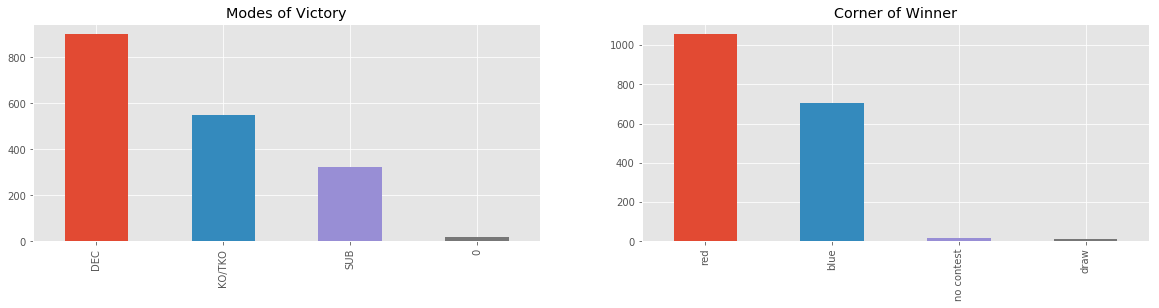

In [6]:
# Plot the modes of victory/loss and which corner wins
f, ax = plt.subplots(figsize=(20,4))
plt.subplot(1,2,1)
ufc['winby'].value_counts().plot(kind='bar')
plt.title('Modes of Victory')
plt.subplot(1,2,2)
ufc['winner'].value_counts().plot(kind='bar')
plt.title('Corner of Winner')
plt.show()

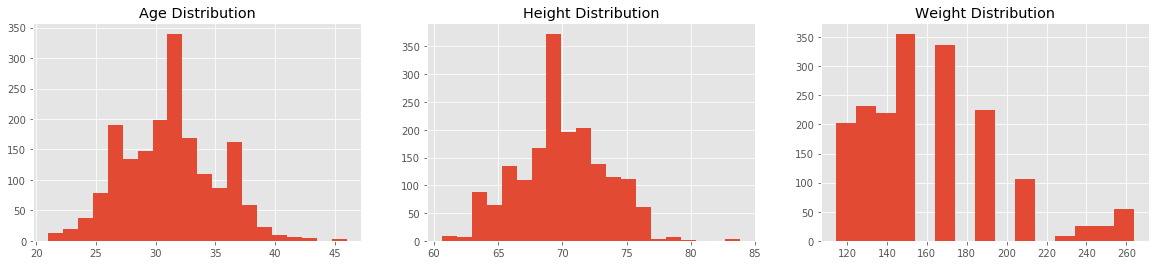

In [7]:
# Plot the age, height and weight distributions
f, ax = plt.subplots(figsize=(20,4))
plt.subplot(1,3,1)
plt.hist(ufc['Age'], bins=20)
plt.title('Age Distribution')
plt.subplot(1,3,2)
plt.hist(ufc['Height']*0.393701, bins=20)
plt.title('Height Distribution')
plt.subplot(1,3,3)
plt.hist(ufc['Weight']*2.2, bins=15)
plt.title('Weight Distribution')
plt.show()

In [8]:
# Remove rows denoting draws and no-contests
ufc = ufc.drop([i for i in ufc.index if (ufc.loc[i,'winner'] == 'draw') | (ufc.loc[i,'winner'] == 'no contest')], axis=0)

In [9]:
# Check the length of the reduced dataset
len(ufc)

1762

### "And In the Blue Corner...."
<img src="44354948440_d50aa203a3_b_van.jpg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     photo credit: MAZA FIGHT JAPAN <a href="http://www.flickr.com/photos/123913273@N06/44354948440">8Y9A1699-109</a> via <a href="http://photopin.com">photopin</a> <a href="https://creativecommons.org/licenses/by-nc-nd/2.0/">(license)</a>
     <br/>
     <br/>
Looking closely at the data, I noted an imbalance between fight winners from the blue and red corners (707 and 1055 respectively). As far as I was aware, the corner colors were assigned at random, in which case one would expect to observe a roughly equal number of winners coming from each class. I decided to test whether the observed imbalance was  likely, if the corner assignments are in fact  random. The method I used was the Chi-square test, a statistical hypothesis test pioneered in 1900 by Karl Pearson. The equation for the Chi-square test incorporates terms for the expected and observed number of results in each possible class: 
<br/>
<br/>

\begin{equation*}
\chi ^2 = 
\sum (\frac{Observed - Expected}{(Expected)}) =
(\frac{Obs. Red Wins - Exp. Red Wins}{(Exp. Red Wins)}) + (\frac{Obs. Blue Wins - Exp. Blue Wins }{(Exp. Blue Wins )})
\end{equation*}
<br/>
The minuscule size of the calculated p-value (1.12E-16) demonstrates that the division between red and blue corner winners is not random. Either the assignation of a corner color has an effect on a fighter's performance (almost like home advantage in other sports), or, more likely, the corners are assigned according to some criterion that correlates with a fighter's ultimate likelihood of winning.

I searched extensively on the internet for any discussion on any logic behind the assignments of fighters to corners. Although I could not find any definitive answers, a number of forum posts did indicate that the favorite (in practice either the champion or the higher-ranked fighter) is usually given the red corner. If true, this would at least partly explain the clear imbalance of victories in favor of the red corner.

In [10]:
# Look at the balance between red and blue winners
ufc['winner'].value_counts()

red     1055
blue     707
Name: winner, dtype: int64

In [11]:
total_fights = 1762
red_wins = ufc['winner'].value_counts()[0]
blue_wins = ufc['winner'].value_counts()[1]

# Perform Chi-square test
chisquare([red_wins,blue_wins])

Power_divergenceResult(statistic=68.73098751418843, pvalue=1.1285363772110076e-16)

In [12]:
# Remove unnecessary columns
ufc_mod = ufc.drop(['Unnamed: 0', 'Date', 'Event_ID', 'Fight_ID', 'Name', 'ID', 'HomeTown', 'Location'], axis=1)
ufc_mod.reset_index(inplace=True)
ufc_mod.drop('index', axis=1, inplace=True)

# Define the fight as a win if 'corner' and 'winner' are the same color
# Else loss
ufc_mod['result'] = ['win' if ufc_mod['winner'][i] == ufc_mod['corner'][i] else 'loss' for i in range(len(ufc_mod))]
ufc_mod['result'].value_counts()

# Remove the now-unnecessary 'winner' col
ufc_mod = ufc_mod.drop(['winner'], axis=1)

In [13]:
# Check the modes of victory
ufc_mod['winby'].value_counts()

DEC       897
KO/TKO    546
SUB       316
0           3
Name: winby, dtype: int64

In [14]:
# Look at the final, modified dataframe
ufc_mod.head()

,winby,corner,Last_round,Max_round,Prev,RStreak,Age,Height,Weight,Round1_Grappling_Reversals_Landed,...,Round5_TIP_Ground Control Time,Round5_TIP_Ground Time,Round5_TIP_Guard Control Time,Round5_TIP_Half Guard Control Time,Round5_TIP_Misc. Ground Control Time,Round5_TIP_Mount Control Time,Round5_TIP_Neutral Time,Round5_TIP_Side Control Time,Round5_TIP_Standing Time,result
0,SUB,blue,1,3,0,0,29.0,162.0,52,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,win
1,DEC,red,3,3,6,2,32.0,162.0,56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,win
2,SUB,red,1,3,5,1,37.0,185.0,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,win
3,DEC,blue,3,3,5,0,27.0,170.0,61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,loss
4,DEC,blue,3,3,1,0,34.0,167.0,61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,win


In [15]:
# Create dummies for categorical variables
ufc_dum = pd.get_dummies(ufc_mod)
# Remove the 'loss' column as it correlates 
# directly against the target variable
ufc_dum = ufc_dum.drop('result_loss', axis=1)
# Another quick look at the data
ufc_dum.head()

,Last_round,Max_round,Prev,RStreak,Age,Height,Weight,Round1_Grappling_Reversals_Landed,Round1_Grappling_Standups_Landed,Round1_Grappling_Submissions_Attempts,...,Round5_TIP_Neutral Time,Round5_TIP_Side Control Time,Round5_TIP_Standing Time,winby_0,winby_DEC,winby_KO/TKO,winby_SUB,corner_blue,corner_red,result_win
0,1,3,0,0,29.0,162.0,52,0.0,0.0,3.0,...,0.0,0.0,0.0,0,0,0,1,1,0,1
1,3,3,6,2,32.0,162.0,56,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,1,1
2,1,3,5,1,37.0,185.0,84,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0,0,1,0,1,1
3,3,3,5,0,27.0,170.0,61,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,1,0,0
4,3,3,1,0,34.0,167.0,61,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,1,0,1


In [16]:
# Create a correlation matrix of our dummies dataframe
# This will be used to extract variables to use in the predictive analysis
corrmat = ufc_dum.corr()

In [17]:
# Check for null values
ufc_dum.isnull().sum().describe()

count    449.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

### Modeling

Having cleaned the data, I was ready to choose predictive models and define functions to classify the data and create plots. I chose 6 of the most popular Supervised Learning algorithms: Logistic Regression (no regularization), Random Forest, Gradient Boosting, K-Nearest Neighbors, XGBoost, and Support Vector Classifier. In all cases the models would classify on a reduced feature set of varying size, with minimal or no tuning of hyperparameters.

### On Feature Selection

Three different methods were used to select features:

1. Pearson correlation (as seen in Python's standard correlation matrix) 

2. ANOVA Filter with Select K-Best

3. Chi-square with Select K-Best. 

For each method, each Supervised Learning model was run using 8-fold cross-validation to highlight any overfitting. The raw accuracy, F1 score and standard deviation of the accuracy were then plotted against the number of variables used. In this way I was able to compare and evaluate the three feature-selection methods for predictive accuracy, and chart the change in accuracy with this increasing number of variables.

In [18]:
# Define the number of variables to be considered
# and the predictive functions to be used

num_vars = np.arange(5,101)

# parameters for the Gradient Boosting model
params = {'n_estimators': 50,
          'max_depth': 10,
          'loss': 'deviance'}

# Instantiate the models to be used
loj = LogisticRegression(C=1e9)
rfc = RandomForestClassifier()
gbc = ensemble.GradientBoostingClassifier(**params)
knn = KNeighborsClassifier(n_neighbors=40, weights='distance')
xgb = XGBClassifier()
svc = SVC()

# Create a dictionary for function calls
# and plot titles
func_dict = {'loj':[loj, 'Logistic Regression'],
             'rfc':[rfc, 'Random Forest Classifier'],
             'gbc':[gbc, 'Gradient Boosted Classifier'],
             'knn':[knn, 'KNN Classifier'],
             'xgb':[xgb, 'XGBoost'],
             'svc':[svc, 'Support Vector Classifier']
            }

# Define a function to predict the outcome (result_win)
# based on variables chosen using Pearson Correlation
def pearson_compute(num_vars,mod,folds):
    accuracy_results = []
    f1_results = []
    sd_results = []
    
    global pearson_variables_60
    
    for n in num_vars:
        # Extract the variables to be used from the corr. matrix
        # Take only the number required according to the value
        # of 'n' i.e. which iteration this is
        pearson_variables = corrmat.loc['result_win',:].sort_values(ascending=False)[1:n].index
        # Define the input and target dataframes
        X = ufc_dum.loc[:, list(pearson_variables)]
        Y = ufc_dum.loc[:, 'result_win']
        
        # Settle on 60 as a desirable no. of variables and the
        # XGBoost algorithm as the most effective
        # Extract the chosen variables for later comparison
        # with other methods
        if n == 61 and mod == xgb:
            pearson_variables_60 = pearson_variables.copy()
        
        # Define train and test datasets for eventual F1 score calculation
        train_data, test_data = train_test_split(ufc_dum, test_size=0.2)       
        X_train, X_test = train_data.loc[:, list(pearson_variables)], test_data.loc[:, list(pearson_variables)]
        Y_train, Y_test = train_data.loc[:, 'result_win'], test_data.loc[:, 'result_win']
        # Fit the model to the data
        mod.fit(X_train,Y_train)
        y_pred = mod.predict(X_test)
        # Compute F1 score
        f1 = f1_score(Y_test, y_pred)        
        f1_results.append(f1)
        
        # Use cross-validation for accuracy score and 
        # standard deviation of accuracy
        cvs = cross_val_score(mod,X,Y,cv=folds)
        accuracy_results.append(cvs.mean())
        sd_results.append(cvs.std())
    return accuracy_results, f1_results, sd_results

# Define a function to predict the outcome (result_win)
# based on a specified number of variables chosen using  
# Chi-Square / Select KBest

def chisquare_compute(num_vars,mod,folds):
    accuracy_results = []
    f1_results = []
    sd_results = []
    
    global kbest_variables_60
    
    # Instantiate SelectKBest via Chi-Square
    fvalue_selector = SelectKBest(chi2)
    # Fit to the input and target dataframes
    fit = fvalue_selector.fit(ufc_dum.drop('result_win',axis=1),ufc_dum['result_win'])
    fit_scores = list(fit.scores_)
    
    # Get the indices of the K Best variables
    for n in num_vars: 
        top_n_indices = list(np.argsort(fit_scores))
        top_n_indices = [value for value in top_n_indices if not np.isnan(fit_scores[value])]      
        top_n_indices = top_n_indices[-n:]
        
        # Get the names of the top variables
        ufc_dum2 = ufc_dum.iloc[:,top_n_indices]
        kbest_variables = list(ufc_dum2.columns)
        
        # Create a variable with the 60 best variables for use later
        if n == 60 and mod == xgb:
            kbest_variables_60 = kbest_variables.copy()
        
        # Define input and target dataframes
        X = ufc_dum.loc[:, kbest_variables]
        Y = ufc_dum.loc[:, 'result_win']
        
        # Define training and test datasets for F1 score calc
        train_data, test_data = train_test_split(ufc_dum, test_size=0.2)
        
        X_train, X_test = train_data.loc[:, kbest_variables], test_data.loc[:, kbest_variables]
        Y_train, Y_test = train_data.loc[:, 'result_win'], test_data.loc[:, 'result_win']        
        mod.fit(X_train,Y_train)
        y_pred = mod.predict(X_test)
        
        f1 = f1_score(Y_test, y_pred)        
        f1_results.append(f1)
        
        # Use cross-validation to compute mean accuracy score
        # and stdev of accuracy
        cvs = cross_val_score(mod,X,Y,cv=folds)
        accuracy_results.append(cvs.mean())     
        sd_results.append(cvs.std())
    return accuracy_results, f1_results, sd_results

In [19]:
# Define another function to plot results based on
# the input model, the number of cross-validation folds,
# and the variable-selection method 
# (Pearson Correlation or Select KBest)

def plot_this(model,folds,function):
    accuracy_results, f1_results, sd_results = function(num_vars,func_dict[model][0],folds)

    f, ax = plt.subplots(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.plot(num_vars, accuracy_results)
    plt.plot(num_vars, f1_results)
    plt.title('{}: Accuracy, F1 scores vs. No. of variables'.format(func_dict[model][1]))
    plt.xlabel('Number of variables used in computation')
    plt.legend(['Accuracy', 'F1-Score'])
    plt.ylim(0.6,0.9)
    plt.ylabel('Accuracy Score')
    
    plt.subplot(1,2,2)
    plt.plot(num_vars, sd_results)
    plt.title('{}: SD of Cross-Validated Accuracy'.format(func_dict[model][1]))
    plt.xlabel('No. of variables used in computation')
    plt.ylim(0,0.04)
    plt.ylabel('SD of Accuracy Score')
    plt.show()

### Train Models Using Different Combos of Algorithm and Feature-Selection Approach


<img src="46850654112_fcc4457f05_o_van.jpg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
photo credit: MAZA FIGHT JAPAN <a href="http://www.flickr.com/photos/123913273@N06/46850654112">8Y9A9111-114</a> via <a href="http://photopin.com">photopin</a> <a href="https://creativecommons.org/licenses/by-nc-nd/2.0/">(license)</a>

### 1. Choose Variables Using Pearson Correlation

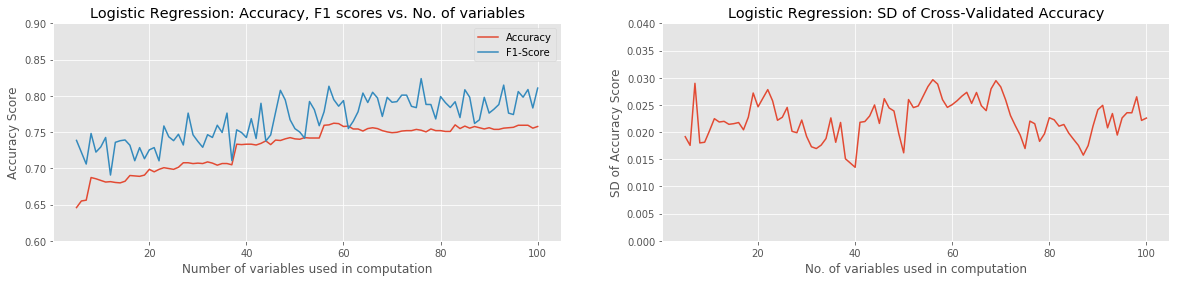

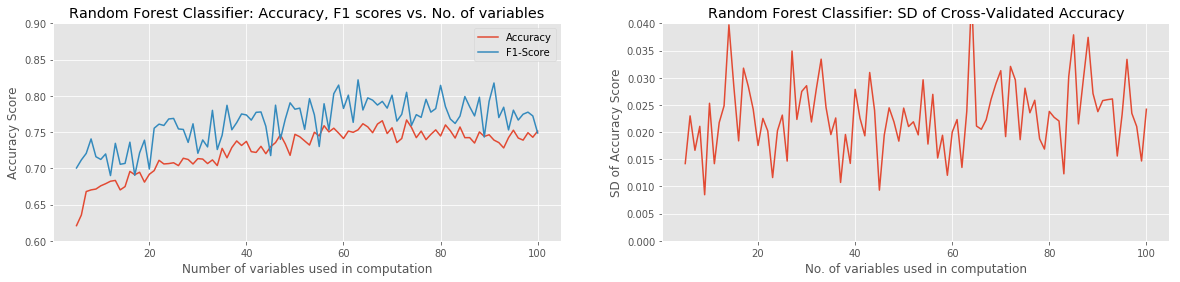

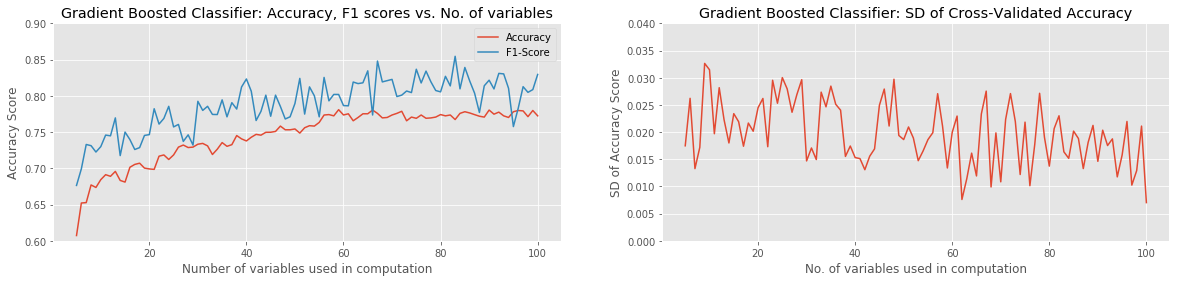

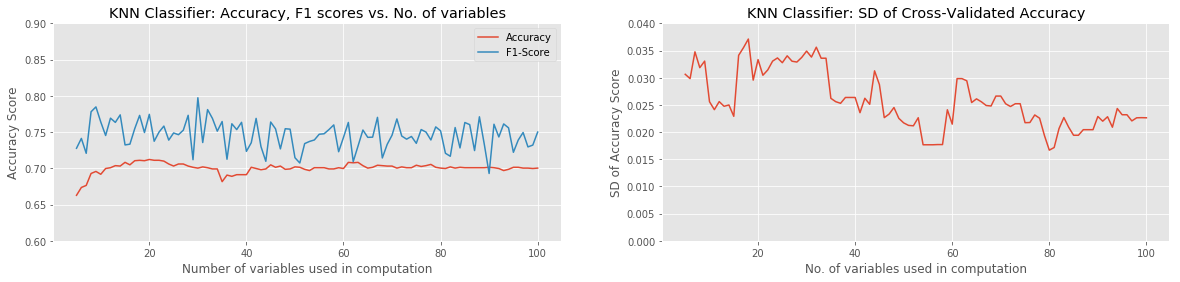

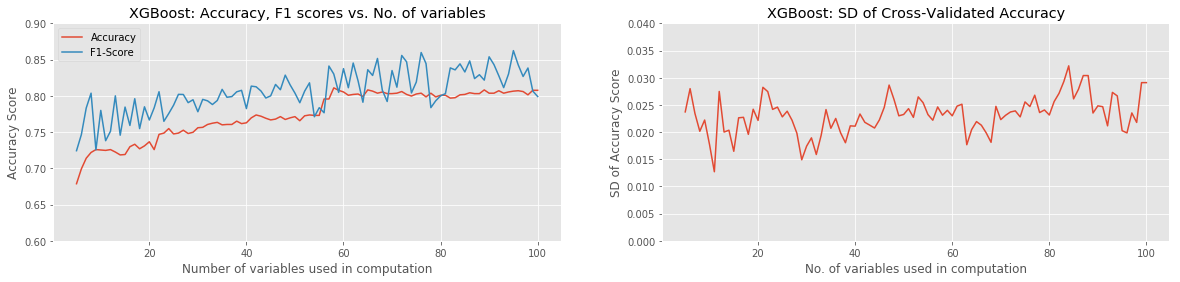

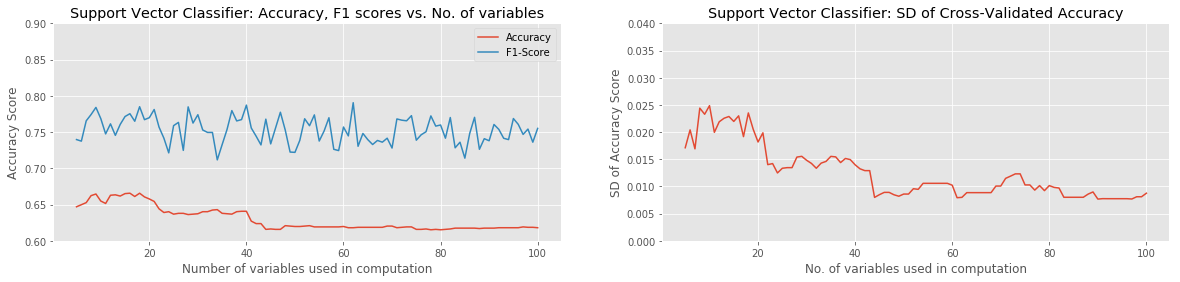

In [20]:
start_time = time.time()
# Plot Accuracy, F1 score, Stdev of accuracy
for key in func_dict:
    plot_this(key,8,pearson_compute)

In [21]:
t = time.time() - start_time
print('Time taken: ', '%.1f' % (t / 60), 'minutes.')

Time taken:  68.9 minutes.


### Check Convergence When No. of Variables Is Increased
Choosing one model (XGBoost) for purely diagnostic purposes, we next try increasing the number of chosen variables to 200, to see whether this yields any improvement in the results. We find that the accuracy and F1 score do not increase beyond the plateau reached at approximately 60 variables; thus we can conclude that there is no need to experiment further with any more than the 100 best variables already tried.

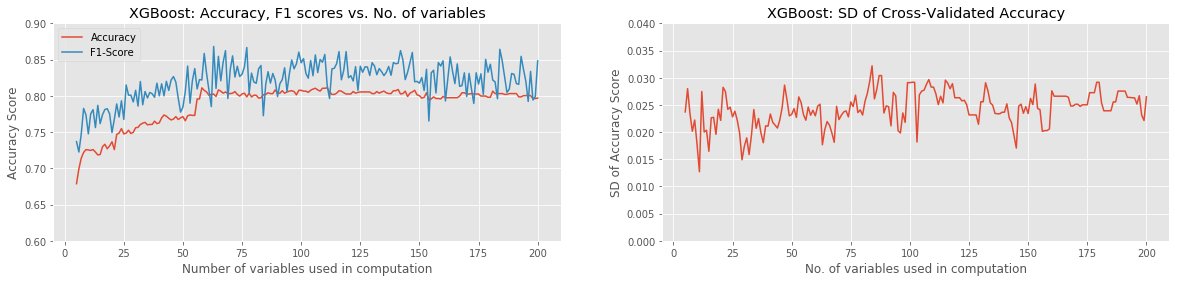

Time taken:  25.7 minutes.


In [22]:
# Set a larger number of iterations to see
# whether accuracy increases or plateaus
num_vars = np.arange(5,201)
start_time = time.time()
plot_this('xgb',8,pearson_compute)
t = time.time() - start_time
print('Time taken: ', '%.1f' % (t / 60), 'minutes.')

# Set num_vars back to its original value
num_vars = np.arange(5,101)

### 2. Choose Variables Using χ2 + Select K-Best

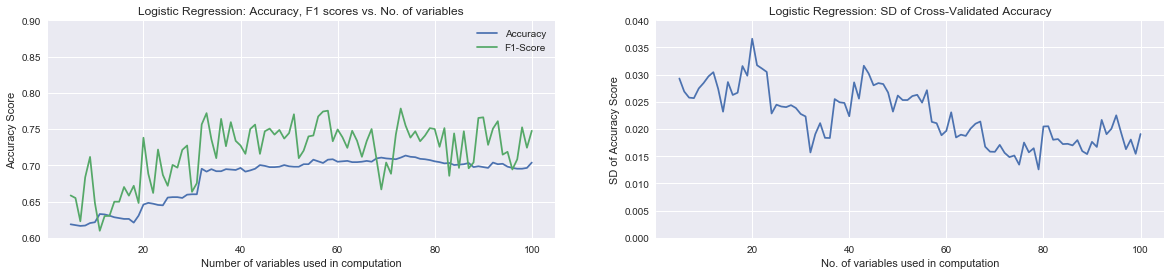

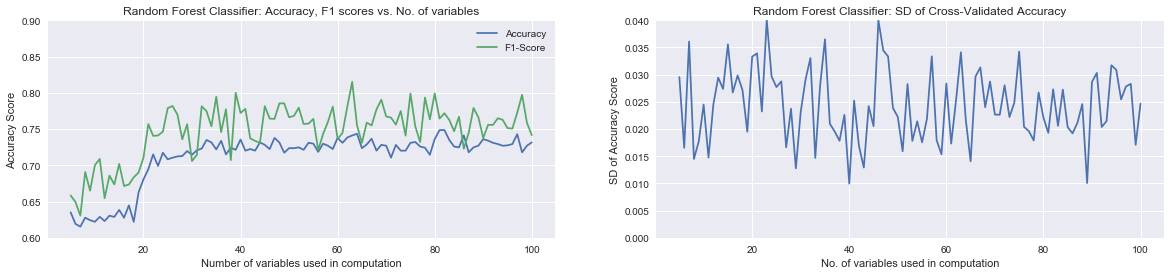

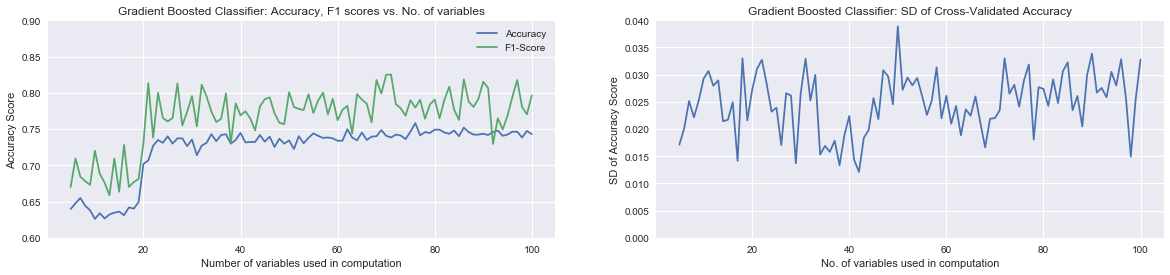

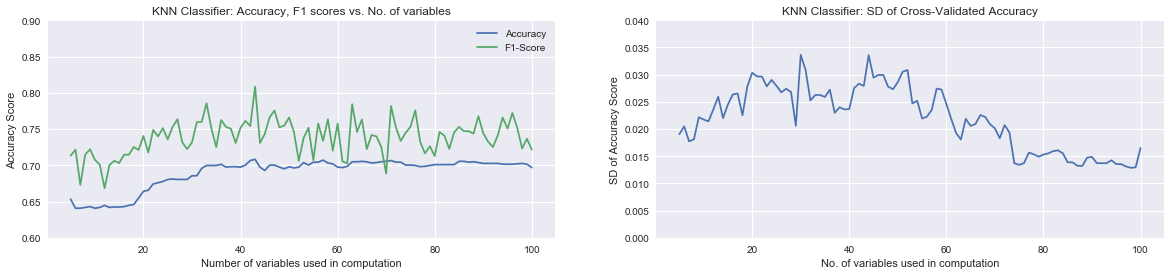

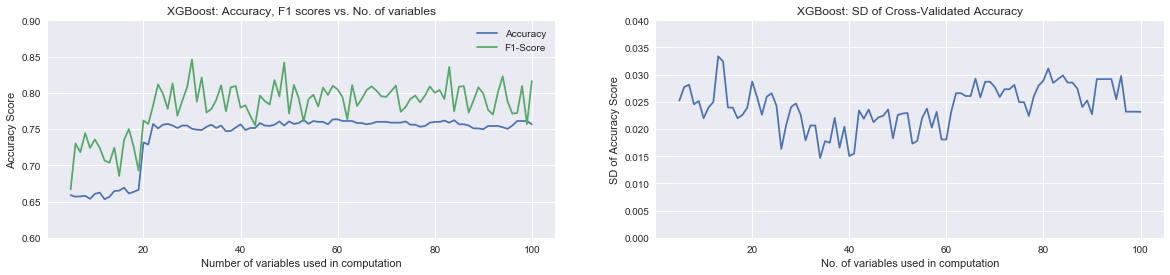

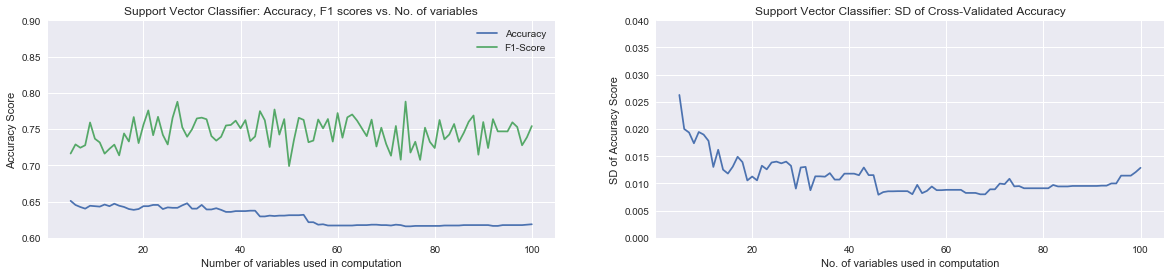

In [23]:
plt.style.use(['seaborn'])
start_time = time.time()
# Plot Accuracy, F1 score, Stdev of accuracy
for key in func_dict:
    plot_this(key,8,chisquare_compute)

In [24]:
t = time.time() - start_time
print('Time taken: ', '%.1f' % (t / 60), 'minutes.')

Time taken:  48.3 minutes.


In [25]:
# Define a dataframe containing the top 60 variables
# obtained using (1) Pearson Correlation and (2) χ2 + Select K-Best
top_variables_comparison = pd.DataFrame({'Top Variables - Pearson Correlation':pearson_variables_60,
                                        'Top Variables - χ2 + Select K-Best':kbest_variables_60})

no_of_shared_variables = [1 for variable in pearson_variables_60 if variable in kbest_variables_60]

# Identify the variables chosen by each method that are not shared between them
pearson_but_not_chi = [variable for variable in pearson_variables_60 if variable not in kbest_variables_60]
chi_but_not_pearson = [variable for variable in kbest_variables_60 if variable not in pearson_variables_60]

# Compute the percentage of shared variables
percentage_of_shared_variables = sum(no_of_shared_variables) * 100/60

# Put the unshared variables into a dataframe
unique_variables = pd.DataFrame({'Variables unique to Pearson':pearson_but_not_chi,
                                'Variables unique to χ2 + Select K-Best':chi_but_not_pearson})

top_variables_comparison

,Top Variables - Pearson Correlation,Top Variables - χ2 + Select K-Best
0,Round2_Strikes_Head Total Strikes_Landed,Round5_TIP_Standing Time
1,Round2_Strikes_Total Strikes_Landed,Round1_TIP_Misc. Ground Control Time
2,Round1_Strikes_Total Strikes_Landed,Round1_Strikes_Significant Strikes_Landed
3,Round1_Strikes_Head Total Strikes_Landed,Round2_Strikes_Head Significant Strikes_Attempts
4,Round2_TIP_Ground Control Time,Round1_Strikes_Head Total Strikes_Attempts
5,Round2_Strikes_Ground Significant Strikes_Atte...,Round1_Strikes_Head Significant Strikes_Landed
6,Round1_Strikes_Ground Significant Strikes_Landed,Round1_Strikes_Total Strikes_Attempts
7,Round2_Strikes_Ground Significant Strikes_Landed,Round2_Strikes_Significant Strikes_Attempts
8,Round2_TIP_Control Time,Round3_TIP_Misc. Ground Control Time
9,Round2_Strikes_Head Significant Strikes_Landed,Round2_TIP_Back Control Time


In [26]:
print('% of shared variables between the top 60 chosen by the two methods: {}'.format(round(percentage_of_shared_variables)))

% of shared variables between the top 60 chosen by the two methods: 83


In [27]:
# Show the variables in each set that  
# are not shared between them
display(unique_variables)

,Variables unique to Pearson,Variables unique to χ2 + Select K-Best
0,corner_red,Round5_TIP_Standing Time
1,Round3_Grappling_Takedowns_Landed,Round1_TIP_Misc. Ground Control Time
2,Round1_Strikes_Knock Down_Landed,Round2_Strikes_Head Significant Strikes_Attempts
3,Round2_Grappling_Takedowns_Landed,Round2_Strikes_Significant Strikes_Attempts
4,Round1_Grappling_Takedowns_Landed,Round3_TIP_Misc. Ground Control Time
5,Round2_Strikes_Body Total Strikes_Landed,Round2_TIP_Back Control Time
6,Round3_Strikes_Body Total Strikes_Landed,Round3_TIP_Back Control Time
7,Round2_Strikes_Knock Down_Landed,Round3_TIP_Side Control Time
8,Round1_Grappling_Submissions_Attempts,Round2_TIP_Guard Control Time
9,Round2_Grappling_Submissions_Attempts,Round1_TIP_Guard Control Time


### 3. Choose Variables Using ANOVA + Select K-Best

In [28]:
# Write function to predict the outcome (result_win)
# based on variables chosen using ANOVA filter with SelectKBest
def anova_compute(num_vars,mod,folds):
    accuracy_results = []
    f1_results = []
    sd_results = []
    
    global kbest_variables_60
    
    # Instantiate Select KBest via ANOVA
    fvalue_selector = SelectKBest(f_classif)
    # Fit to the input and target dataframes
    fit = fvalue_selector.fit(ufc_dum.drop('result_win',axis=1),ufc_dum['result_win'])
    fit_scores = list(fit.scores_)
    
    # Iterate through the preset value of num_vars
    for n in num_vars:
        # State the indices of the top 'n' variables
        top_n_indices = list(np.argsort(fit_scores))
        top_n_indices = [value for value in top_n_indices if not np.isnan(fit_scores[value])]      
        top_n_indices = top_n_indices[-n:]
        
        # Isolate the corresponding top variables from their indices
        ufc_dum2 = ufc_dum.iloc[:,top_n_indices]
        kbest_variables = list(ufc_dum2.columns)
        
        # Create a variable with the 60 best variables for use later
        if n == 60 and mod == xgb:
            kbest_variables_60 = kbest_variables.copy()
        # Define the final input and outcome dataframes
        # based on the chosen K-Best variables 
        X = ufc_dum.loc[:, kbest_variables]
        Y = ufc_dum.loc[:, 'result_win']
        
        # Create training and test datasets for F1 score calculation
        train_data, test_data = train_test_split(ufc_dum, test_size=0.2)
        
        X_train, X_test = train_data.loc[:, kbest_variables], test_data.loc[:, kbest_variables]
        Y_train, Y_test = train_data.loc[:, 'result_win'], test_data.loc[:, 'result_win']
        
        # Fit the model to the data
        mod.fit(X_train,Y_train)
        y_pred = mod.predict(X_test)
        # Compute the F1 score and add to the list
        f1 = f1_score(Y_test, y_pred)        
        f1_results.append(f1)
        # Compute cross-validated accuracy 
        # and standard deviation scores     
        cvs = cross_val_score(mod,X,Y,cv=folds)
        accuracy_results.append(cvs.mean())    
        sd_results.append(cvs.std())
    return accuracy_results, f1_results, sd_results

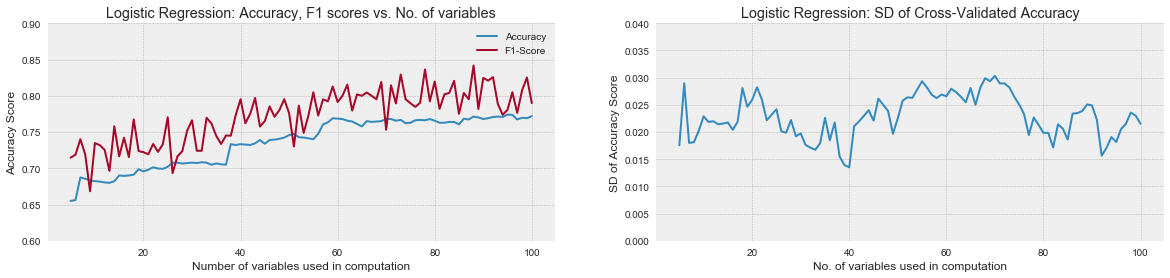

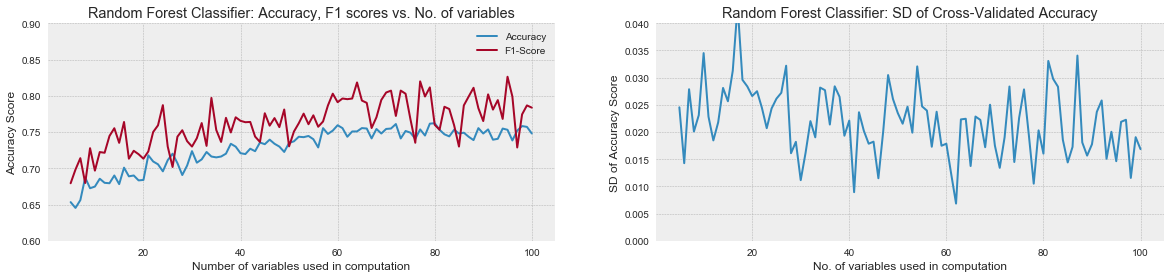

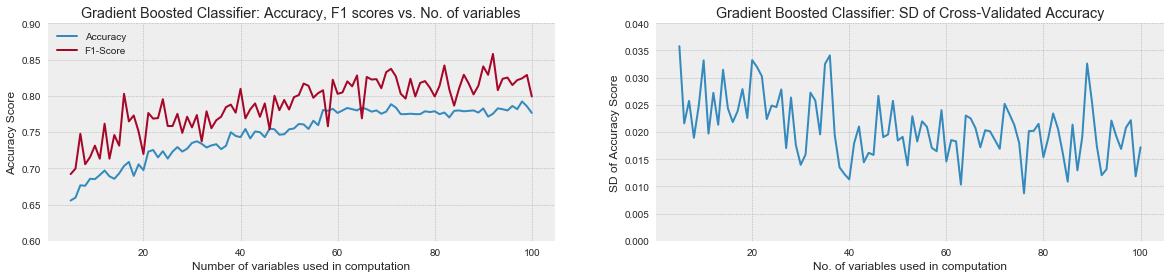

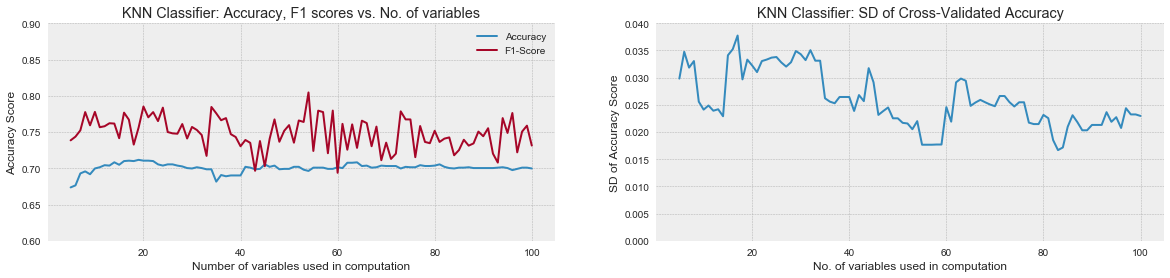

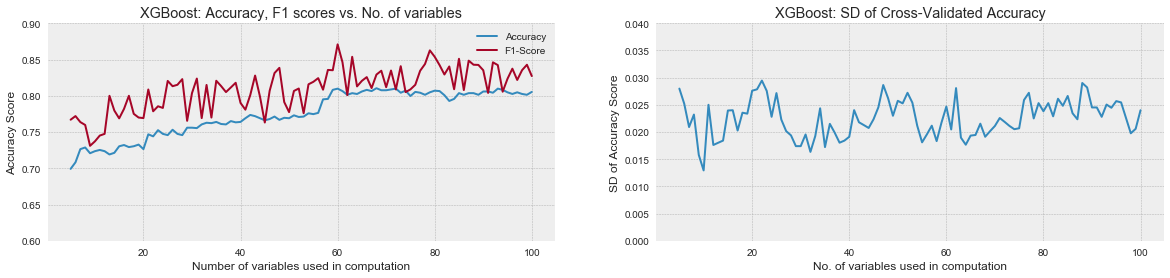

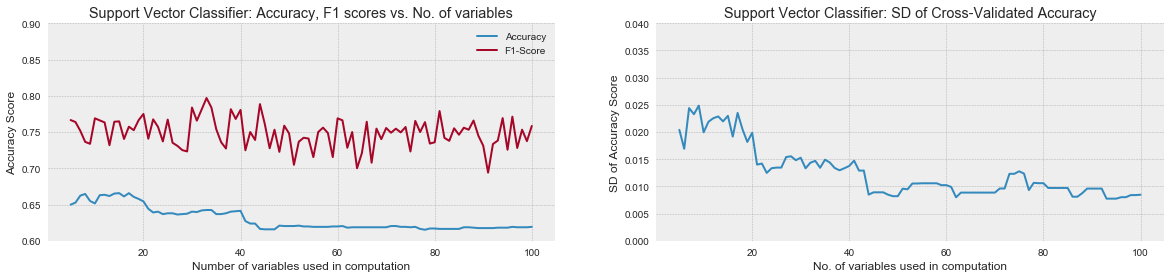

In [29]:
plt.style.use(['bmh'])
start_time = time.time()
# Plot Accuracy, F1 score, Stdev of accuracy
for key in func_dict:
    plot_this(key,8,anova_compute)

In [30]:
t = time.time() - start_time
print('Time taken: ', '%.1f' % (t / 60), 'minutes.')

Time taken:  46.2 minutes.


In [31]:
# Define a dataframe containing the top 60 variables
# obtained using (1) Pearson Correlation and (2) Select K-Best (ANOVA)
top_variables_comparison = pd.DataFrame({'Top Variables - Pearson Correlation':pearson_variables_60,
                                        'Top Variables - Select K-Best (ANOVA)':kbest_variables_60})

no_of_shared_variables = [1 for variable in pearson_variables_60 if variable in kbest_variables_60]

percentage_of_shared_variables = sum(no_of_shared_variables) * 100/60

display(top_variables_comparison)

,Top Variables - Pearson Correlation,Top Variables - Select K-Best (ANOVA)
0,Round2_Strikes_Head Total Strikes_Landed,Round3_Strikes_Head Total Strikes_Attempts
1,Round2_Strikes_Total Strikes_Landed,Round2_Grappling_Submissions_Attempts
2,Round1_Strikes_Total Strikes_Landed,Round2_TIP_Side Control Time
3,Round1_Strikes_Head Total Strikes_Landed,Round1_Grappling_Submissions_Attempts
4,Round2_TIP_Ground Control Time,Round2_Strikes_Knock Down_Landed
5,Round2_Strikes_Ground Significant Strikes_Atte...,Round1_TIP_Half Guard Control Time
6,Round1_Strikes_Ground Significant Strikes_Landed,Round3_TIP_Mount Control Time
7,Round2_Strikes_Ground Significant Strikes_Landed,Round3_Strikes_Total Strikes_Attempts
8,Round2_TIP_Control Time,Round3_Strikes_Body Total Strikes_Landed
9,Round2_Strikes_Head Significant Strikes_Landed,Round2_Strikes_Body Total Strikes_Landed


In [32]:
print('% of shared variables between the top 60 chosen by the two methods: {}'.format(round(percentage_of_shared_variables)))

% of shared variables between the top 60 chosen by the two methods: 97


### Results

From the charts, it is apparent that the best combination of Machine Learning Model and Feature-Selection method was XGBoost with either Pearson Correlation or ANOVA with SelectKBest. Both combinations were able to reach a raw classification accuracy over 80%, with a peak F1 score of around 85%, using approximately the 60 best variables. Most model combinations were able to achieve around 65% accuracy and 70% F1 score with as few as 5 variables used. Of all models, only the KNN Classifier and Support Vector Classifier failed to gain in accuracy with the addition of more input variables. The SVC actually performed progressively worse as more variables were added. In all cases, χ2 with Select K-Best underperformed the other two Feature-Selection methods.

The standard deviation of the (8-fold) cross-validated accuracy showed the most variation in the case of the Random Forest Classifier. This is an obvious and unsurprising indication that a significant amount of overfitting was occurring at least on some iterations.

#### To Grapple or Not to Grapple?

The notebook shows that the Pearson Correlation and ANOVA-SelectKBest Feature Selection methods share 97% of their 60 top-ranked variables in common. This ties in with their very similar accuracy and F1 scores. However, the χ2-Select K-Best method only shared 83% of its variables with the Pearson Correlation approach. Looking at the table of variables that were *not* shared by the se two methods, we see the following:

| Variables unique to Pearson | Variables unique to χ2 + Select K-Best |
| :-------------------------   |:-----------------------------------    |
|	corner_red	|Round5_TIP_Standing Time |
|	Round3_Grappling_Takedowns_Landed	| Round1_TIP_Misc. Ground Control Time |
|	Round1_Strikes_Knock Down_Landed |	Round2_Strikes_Head Significant Strikes_Attempts |
|	Round2_Grappling_Takedowns_Landed |	Round2_Strikes_Significant Strikes_Attempts |
|	Round1_Grappling_Takedowns_Landed |	Round3_TIP_Misc. Ground Control Time |
|	Round2_Strikes_Body Total Strikes_Landed |	Round2_TIP_Back Control Time |
|	Round3_Strikes_Body Total Strikes_Landed |	Round3_TIP_Back Control Time |
|	Round2_Strikes_Knock Down_Landed |	Round3_TIP_Side Control Time |
|	Round1_Grappling_Submissions_Attempts |	Round2_TIP_Guard Control Time |
|	Round2_Grappling_Submissions_Attempts |	Round1_TIP_Guard Control Time |

Given that the χ2-Select K-Best analysis was significantly less accurate than the Pearson method, we can infer that the variables identified by that method, that were NOT shared by the Pearson Correlation variables, were less important in predicting a win for the fighter in question. Of these 10 variables, 7 relate to grappling 'Time in Play', whether through back control, side control, or guard control. This makes sense when one considers that the time spent controlling one's opponent is not necessarily decisive in a fight; rather, what determines the outcome of the fight is what the fighter actually does with that time. 

Looking at the variables identified by Pearson Correlation that were not shared by the χ2-Select K-Best, 7 involve strikes landed, or takedowns achieved; that is to say, they relate to actions successfully completed, rather than time spent. It stands to reason that these variables would have a greater influence in deciding the outcome than simply time spent in control, without necessarily capitalizing on one's position with strikes or a submission attempt. 

<img src="43389854625_fa69df0958_o_van.jpg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
photo credit: MAZA FIGHT JAPAN <a href="http://www.flickr.com/photos/123913273@N06/43389854625">8Y9A9326-198</a> via <a href="http://photopin.com">photopin</a> <a href="https://creativecommons.org/licenses/by-nc-nd/2.0/">(license)</a>

### Appendix: What If We Only Use Purely Predictive Variables?

As discussed at the start, the dataframe used contains a lot of variables pertaining to what transpires during the fight. I decided to try restricting the analysis to only the handful of variables that are known *prior* to the fight. Due to a lack of correlation between those few variables and the outcome variable, I ultimately settled on three variables: corner_red (addressed earlier), Prev, and Age. Since the values of the latter two correlations had magnitudes below 0.1, I expected the predicted results to be largely a function of the corner_red variable, and that predictive accuracy would be relatively poor. And so it proved. 

The stripped-down model seems to rely largely on the corner_red variable for what little predictive power it has. As such, with the best-performing of the models (Logistic Regression) was only able to achieve a raw predictive accuracy of 0.623 +/- 0.054, with F1 scores ranging from 54% to 67%:

In [33]:
# Isolate the variables known BEFORE the fight
chosen_variables = ['corner_red', 'Max_round', 'Prev', 'RStreak', 'Age', 'Height', 'Weight']

# From this correlation matrix we see only 3 variables that
# correlate much with target variable, either +vely or -vely
# 'corner_red', 'Prev' and 'Age'
corrmat2 = ufc_dum.loc[:, chosen_variables + ['result_win']].corr()
corrmat2

,corner_red,Max_round,Prev,RStreak,Age,Height,Weight,result_win
corner_red,1.000000,-0.005336,0.117099,0.038262,0.056613,-0.010015,0.012615,0.197477
Max_round,-0.005336,1.000000,0.081932,0.222095,0.162239,0.014981,0.096424,-0.032527
Prev,0.117099,0.081932,1.000000,0.543378,0.018255,0.054649,0.053070,0.082673
RStreak,0.038262,0.222095,0.543378,1.000000,-0.059060,0.001081,-0.021730,0.014749
Age,0.056613,0.162239,0.018255,-0.059060,1.000000,0.156059,0.298937,-0.089105
Height,-0.010015,0.014981,0.054649,0.001081,0.156059,1.000000,0.803707,-0.008825
Weight,0.012615,0.096424,0.053070,-0.021730,0.298937,0.803707,1.000000,-0.014524
result_win,0.197477,-0.032527,0.082673,0.014749,-0.089105,-0.008825,-0.014524,1.000000


In [34]:
# Re-write function to predict the outcome (result_win) based on 
# only a few variables denoting information known BEFORE the fight
def prefight_compute(mod,folds):
    # Create a list containing the chosen variables
    chosen_variables = ['corner_red', 'Prev', 'Age']

    # Define the final input and outcome dataframes
    # based on the chosen variables 
    X = ufc_dum.loc[:, chosen_variables]
    Y = ufc_dum.loc[:, 'result_win']

    # Compute cross-validated accuracy 
    # and standard deviation scores     
    cvs = cross_val_score(mod,X,Y,cv=folds)
    cvs = np.array([round(value,3) for value in cvs]) 
    cvs_mean = round(cvs.mean(),3)
    # Compute F1 scores of each cross-validation fold
    f1 = cross_val_score(mod,X,Y,cv=folds,scoring='f1_macro')
    f1 = np.array([round(value,3) for value in f1])
    # Output results summary
    print('Cross-validated Accuracy: {} +/- {}'.format(cvs_mean, 2 * round(cvs.std(),3)))
    print('Raw Accuracy Scores: {}'.format(cvs))
    print('F1 Scores: {}'.format(f1))

In [35]:
for key in func_dict:
    print('{}:'.format(str(func_dict[key][1])))
    prefight_compute(func_dict[key][0],8)
    print('*' * 30, '\n')

Logistic Regression:
Cross-validated Accuracy: 0.623 +/- 0.054
Raw Accuracy Scores: [0.602 0.638 0.602 0.629 0.624 0.612 0.594 0.685]
F1 Scores: [0.536 0.56  0.54  0.584 0.602 0.576 0.581 0.676]
****************************** 

Random Forest Classifier:
Cross-validated Accuracy: 0.57 +/- 0.068
Raw Accuracy Scores: [0.557 0.566 0.525 0.529 0.584 0.607 0.566 0.63 ]
F1 Scores: [0.54  0.554 0.491 0.458 0.524 0.546 0.525 0.605]
****************************** 

Gradient Boosted Classifier:
Cross-validated Accuracy: 0.572 +/- 0.052
Raw Accuracy Scores: [0.548 0.602 0.557 0.529 0.602 0.58  0.562 0.598]
F1 Scores: [0.518 0.549 0.52  0.468 0.567 0.554 0.542 0.59 ]
****************************** 

KNN Classifier:
Cross-validated Accuracy: 0.562 +/- 0.078
Raw Accuracy Scores: [0.552 0.606 0.525 0.484 0.584 0.589 0.562 0.598]
F1 Scores: [0.537 0.568 0.505 0.445 0.564 0.573 0.55  0.598]
****************************** 

XGBoost:
Cross-validated Accuracy: 0.61 +/- 0.068
Raw Accuracy Scores: [0.561 0.6